# Part 1: Common Analysis

 The course project is broken into four parts:   
- Part 1 - Common Analysis sets the stage for the subsequent assignments. In A4 you conduct a base analysis. All of the students in the class will conduct the same analysis, but with a slightly different data subset.
- Part 2 - Extension Plan will require you to ask a human centered data science question that extends the work in A4: Common Analysis. 
- Part 3 - Presentation will require you to give a modified (shorter) [PechaKucha](https://en.wikipedia.org/wiki/PechaKucha) presentation of your completed project.
- Part 4 - Project Repository, creation of a fully documented repository and also requires the submission of a written project report.


In [1]:
# Loading all the libraries that would be required for this analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
import ruptures as rpt
import matplotlib.patches as mpatches

## Step 0: Data Acquisition

1. The RAW_us_confirmed_cases.csv file from the Kaggle repository of [John Hopkins University COVID-19 data](https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university). This data is updated daily. You can use any revision of this dataset posted after October 1, 2022.
2. The CDC dataset of [masking mandates by county](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i). Note that the CDC stopped collecting this policy information in September 2021.
3. The New York Times [mask compliance survey](https://github.com/nytimes/covid-19-data/tree/master/mask-use) data.  
### US County Assigned: San Mateo, CA

In [2]:
confirmed_cases = pd.read_csv('RAW_us_confirmed_cases.csv')
masking_mandate = pd.read_csv('cdc_masking_mandates_county.csv')
mask_use = pd.read_csv('mask-use-by-county.csv')

Loading all the raw data files into dataframes: -
- confirmed_cases: contains the raw file of RAW_us_confirmed_cases.csv
- masking_mandate: contains the data file as downloaded from the CDC dataset for masking mandates by county
- mask_use: contains the data set as downloaded from the NYT website for the mask compliance survey

## Step 1: Analyze

**Research question** : How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?

## Data Cleaning and Standardization

### 1. For the confirmed cases per county

In [3]:
# Creating a sub-data frame which has the data of the desired county only
# Province_State = California and Admin2 = San Mateo

county_cases = confirmed_cases[(confirmed_cases["Province_State"] == "California") & 
                               (confirmed_cases["Admin2"] == "San Mateo")]

#Viewing the dataframe to understand it better
county_cases

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
238,California,San Mateo,84006081,US,USA,840,6081.0,US,37.422881,-122.327555,...,180152,180152,180152,180609,180609,180610,180611,180611,180611,180611


We see the FIPS score will be needed for accessing the mask_use dataframe, hence storing that value is a variable called 'san_mateo_FIPS'

In [4]:
san_mateo_FIPS = county_cases['FIPS'].values[0]
san_mateo_FIPS

6081.0

Looking at all the column names in county_cases, not all of them are useful/needed. Thus we create a new dataframe to just keep only the relevant date columns.
Columns 21 onwards is from Feb 01, 2020.

In [5]:
county_cases_bydate = county_cases[county_cases.columns[21:]]
county_cases_bydate = pd.DataFrame(county_cases_bydate.iloc[0])
county_cases_bydate = county_cases_bydate.reset_index()
county_cases_bydate.columns = ["date", "confirmed_cases"]

Converting the 'date' column to 'datetime' type so that we can use *filter* to get the desired subset of the desired date range. i.e., February 1, 2020 through October 1, 2021

In [6]:
county_cases_bydate['date'] = pd.to_datetime(county_cases_bydate['date'])
county_cases_bydate = county_cases_bydate.loc[(county_cases_bydate['date'] <= '2021-10-01')]

After creating the dataframe, we want to check if there are any missing values before proceeding onto cleaning the other dataframes.

In [7]:
county_cases_bydate.isna().sum()

date               0
confirmed_cases    0
dtype: int64

Windowing the data to **weekly** to smoothen the noise and interpret better.

In [8]:
county_cases_bydate['confirmed_cases'] = county_cases_bydate['confirmed_cases'].rolling(7).mean()
county_cases_bydate = county_cases_bydate.fillna(0)

Confirmed cases is to be the cumulative number of cases confirmed. Thus daily confirmed cases will be a a delta change thus clculating the gradient of the cases to get daily confirmed cases.

In [9]:
county_cases_bydate["confirmed_cases"] = pd.Series(np.gradient(county_cases_bydate["confirmed_cases"]), 
                                             county_cases_bydate["date"], name='confirmed_cases').values
# Taking the absolute as there are very few places where the delta change is 
# negative and this could be an issue of data entry.

county_cases_bydate["confirmed_cases"] = county_cases_bydate["confirmed_cases"].abs()

# For the purpoe of time series analysis, converting the dataframe into a series
# With date set as the index
county_cases_bydate = county_cases_bydate.set_index('date') 
county_cases_bydate

,confirmed_cases
date,
2020-02-01,0.000000
2020-02-02,0.000000
2020-02-03,0.000000
2020-02-04,0.000000
2020-02-05,0.000000
...,...
2021-09-27,68.500000
2021-09-28,70.000000
2021-09-29,71.071429


### 2. For masking mandate per county dataframe

In [10]:
# Creating a 'm_mandate_county' dataframe to store the respectove data for San Mateo, CA

m_mandate_county = masking_mandate[(masking_mandate["County_Name"] == "San Mateo County") & 
                               (masking_mandate["State_Tribe_Territory"] == "CA")]

In [11]:
m_mandate_county.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
60116,CA,San Mateo County,6,81,4/10/2020,2,NaN,NaN,NaN,NaN
60117,CA,San Mateo County,6,81,4/11/2020,2,NaN,NaN,NaN,NaN
60118,CA,San Mateo County,6,81,4/12/2020,2,NaN,NaN,NaN,NaN
60119,CA,San Mateo County,6,81,4/13/2020,2,NaN,NaN,NaN,NaN
60120,CA,San Mateo County,6,81,4/14/2020,2,NaN,NaN,NaN,NaN


Looking are the dataframe we can see that the columns of interest for us would be "date" and "Face_Masks_Required_in_Public"

In [12]:
m_mandate_county = m_mandate_county.filter(['date', 'Face_Masks_Required_in_Public'], axis = 1)

# Checking for the kinds of values present in the dataframe
m_mandate_county.Face_Masks_Required_in_Public.unique()

array([nan, 'Yes'], dtype=object)

As we can see, NAN can be replaced with "No" as there is no other option int he dataframe other than 'Yes' and 'NAN'

In [13]:
m_mandate_county["Face_Masks_Required_in_Public"] = m_mandate_county["Face_Masks_Required_in_Public"].fillna("No")

# Converting date as string to date-time format
# To be able to set it as an index
m_mandate_county['date'] = pd.to_datetime(m_mandate_county['date'])
m_mandate_county = m_mandate_county.set_index('date')
m_mandate_county

,Face_Masks_Required_in_Public
date,
2020-04-10,No
2020-04-11,No
2020-04-12,No
2020-04-13,No
2020-04-14,No
...,...
2021-08-11,Yes
2021-08-12,Yes
2021-08-13,Yes


### 3. For mask compliance survey data

Saving the data for San Mateo by using the FIPS value we saved earlier in step 1 to a new data frame called 'mask_survey'

In [14]:
mask_survey = mask_use[mask_use['COUNTYFP'] == int(san_mateo_FIPS)]

# viewing the dataframe
mask_survey

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
226,6081,0.016,0.013,0.058,0.126,0.786


## Step 2: Visualize

In this step we want you to create a graph that visualizes how the course of the disease was changed by masking policies. For your county, you should create a time series showing the changes in the derivative function of the rate of infection. Your graph should indicate days where masking policies were in effect (or not) and whether the difference in the derivative function was significant. 

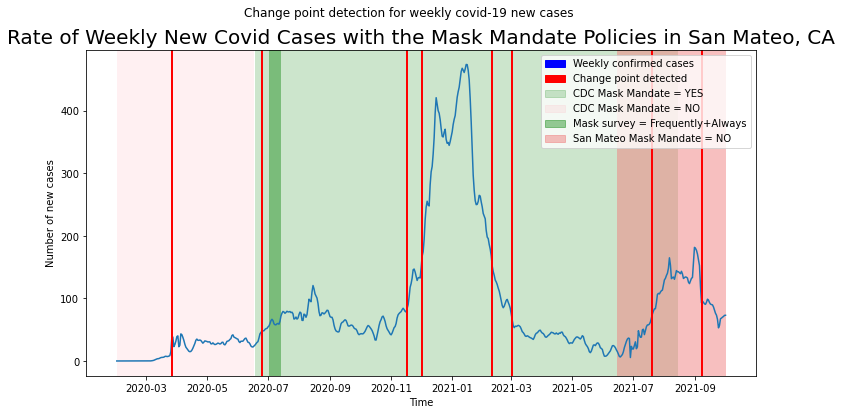

In [19]:
# Using the ruptures package for detecting change point
# Pelt Search Method

data = np.array(county_cases_bydate)
algo = rpt.Pelt(model="rbf").fit(data)

change_locations = algo.predict(pen=10)
change_locations = county_cases_bydate.iloc[change_locations[:-1]].index.to_list()

plt.figure(figsize=(12,6))
plt.plot(county_cases_bydate)

# Plotting red horizontal lines for days when a change point is detected
for i in change_locations:
    plt.axvline(i,lw=2, color='red')
    
red_patch = mpatches.Patch(color='red', label='Change point detected')
blue_patch = mpatches.Patch(color='b', label='Weekly confirmed cases')

# -------------------------------------------------------------------------------------------
# Adding titles and labels for the visualization    
plt.title('Rate of Weekly New Covid Cases with the Mask Mandate Policies in San Mateo, CA', 
          fontdict = {'fontsize' : 20})
plt.suptitle('Change point detection for weekly covid-19 new cases ', 
          fontdict = {'fontsize' : 20})
plt.xlabel('Time')
plt.ylabel('Number of new cases')

# -------------------------------------------------------------------------------------------
# As per CDC data
# lighter green background = Mask mandate is YES
# from the dataframe above 'm_mandate_county'

plt.axvspan('2020-06-18', '2021-08-15', facecolor='g', alpha=0.2)
lgreen_patch = mpatches.Patch(color='g', alpha=0.2, label='CDC Mask Mandate = YES')

# -------------------------------------------------------------------------------------------
# Estimates from The New York Times, based on roughly 250,000 interviews conducted by Dynata 
# from July 2 to July 14, 2020

# From the dataframe 'mask_survey', frequently+always mask = 91.2%
# hence darker green window for this time period

plt.axvspan('2020-07-02', '2020-07-14', facecolor='g', alpha=0.4)
dgreen_patch = mpatches.Patch(color='g', alpha=0.4, label='Mask survey = Frequently+Always')

# -------------------------------------------------------------------------------------------
# From the CDC data in the dataframe 'm_mandate_county' and from the internet that prior to 
# the start of 4/10/20 there was no mask mandate.
# pink background = Mask Mandate is NO

plt.axvspan('2020-02-01', '2020-06-17', facecolor='lightpink', alpha=0.2)
lpink_patch = mpatches.Patch(color='lightpink', alpha=0.2, label='CDC Mask Mandate = NO')

# -------------------------------------------------------------------------------------------
# Using government website notice on the current mask mandate (As the CDC data is limited)
# We see from the below source that as of June 15, 2021 - NO MASK MANDATE
# source: smcgoc.org
# link: https://www.smcgov.org/san-mateo-county-reopening

plt.axvspan('2021-06-15', '2021-10-01', facecolor='lightcoral', alpha=0.5)
lcoral_patch = mpatches.Patch(color='lightcoral', alpha=0.5, label='San Mateo Mask Mandate = NO')

# -------------------------------------------------------------------------------------------
# Passing all the patches arguments to the legend parameter
plt.legend(handles=[blue_patch, red_patch, lgreen_patch, lpink_patch, dgreen_patch, lcoral_patch])

In [16]:
# Saving the above figure as a .png file
plt.savefig('part1_output_viz.png')
plt.show()

<Figure size 432x288 with 0 Axes>